In [1]:
#Nathan Li - U.S. Airline Sentiments

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-airline-sentiment/Tweets.csv
/kaggle/input/twitter-airline-sentiment/database.sqlite


In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score #used instead of MAE because the Titanic problem is a classification type, not regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from nltk.corpus import stopwords
import re
import collections
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib
import matplotlib.pyplot as plt
import squarify
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

# Introduction
In this notebook, we'll be using **U.S. airline reviews** from twitter to create a machine learning model that can automatically **categorize tweets** into groups of **sentiments**. With this information, we will then try to narrow down what is causing different reviews. This will allow us to determine what airlines are doing good, what they're doing poorly, and how they can improve their customer experience.
<img src= "https://miro.medium.com/max/3200/0*Cg8aS-IHThErnRrz" alt ="Airlines on Twitter" style='width: 500px;'>

# Data Exploration
Before we start training a model, let's try to get an idea of what information we have at our disposal. We should try to figure out which features seem important, which columns need cleaning, and what trends initially stand out.

In [3]:
review_data = pd.read_csv("/kaggle/input/twitter-airline-sentiment/Tweets.csv")
review_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
review_data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


Text(0.5, 1.0, 'Frequency of Review Types')

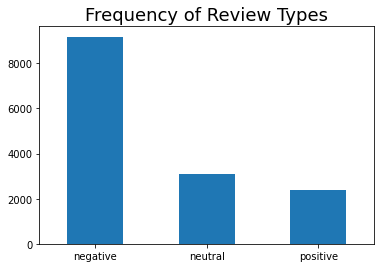

In [5]:
review_data.airline_sentiment.value_counts().plot(kind = "bar")
plt.xticks(rotation=0)
plt.title("Frequency of Review Types", size=18)

An initial graphing of review type frequencies suggest that airlines receive overwhelmingly negative reviews. However, these reviews should be taken with a grain of salt because it is very likely that customer review bias is affecting this. That is the idea that unless a person really loved or hated their customer experience, then they're not likely to spend the effort posting a review. This means that companies often receive disproportionate reviews.

In order to get a better idea of what's causing these different review types, let's try to get a bit more specific. First, we can begin by looking at which airlines are being reviewed.

Text(0.5, 1.0, 'Airline Distribution')

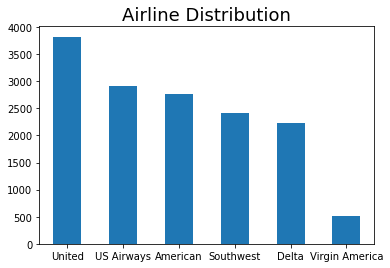

In [6]:
review_data.airline.value_counts().plot(kind = "bar")
plt.xticks(rotation=0)
plt.title("Airline Distribution", size=18)

Next, we can look at the review sentiment frequencies for each airline individually.

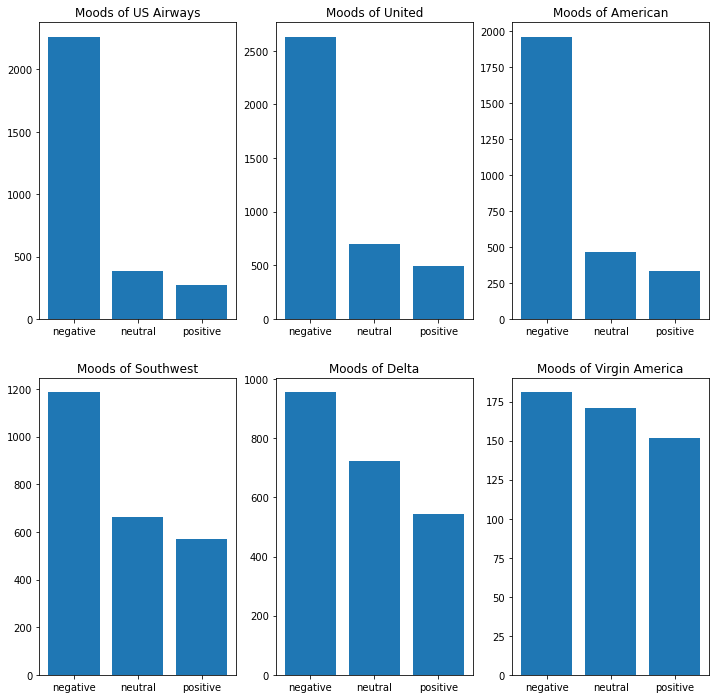

In [7]:
def plot_sub_sentiment(Airline):
    df=review_data[review_data['airline']==Airline]
    count=df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count)
    plt.xticks(Index,['negative','neutral','positive'])
    plt.title('Moods of '+Airline)
plt.figure(1,figsize=(12, 12))
plt.subplot(231) #integers correspond to nrows, ncolumns, and index of the subplot grid. In this case, US Airways is being placed in index 1 of the 2x3 subplot
plot_sub_sentiment('US Airways')
plt.subplot(232)
plot_sub_sentiment('United')
plt.subplot(233)
plot_sub_sentiment('American')
plt.subplot(234)
plot_sub_sentiment('Southwest')
plt.subplot(235)
plot_sub_sentiment('Delta')
plt.subplot(236)
plot_sub_sentiment('Virgin America')

It looks like the three airlines in the top row (US Airways, United, American) have unnusually high proportions of negative reviews, whereas the three airlines in the bottom row (Southwest, Delta, Virgin America) are a little more balanced. Let's try to take a look at exactly what causes these different reviews.

A good method for pulling out some initial insights is to create a **wordcloud of most common words** in different kinds of reviews. Let's start with **negative reviews.**

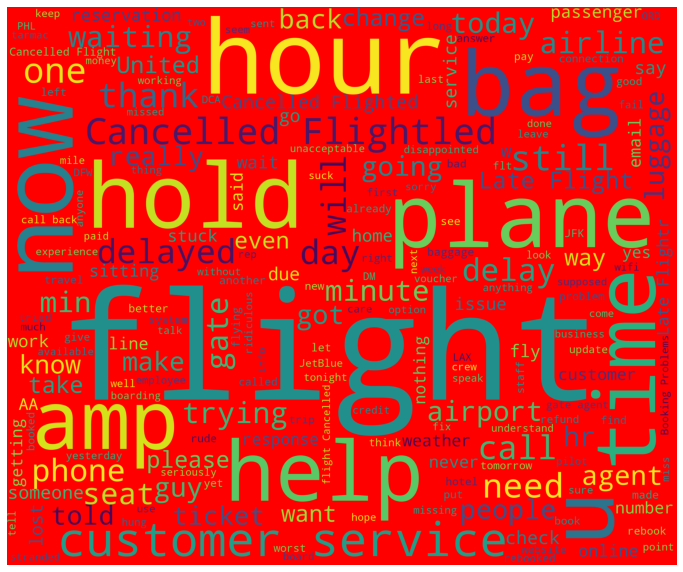

In [8]:
new_df=review_data[review_data['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='red',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
#def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
#    return("hsl(247,35%%, %d%%)" % np.random.randint(49,51))
#wordcloud.recolor(color_func = grey_color_func)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Some of the key words for negative reviews, including "hold", "hour", "time" and "delay" seem to make sense for customers that are frustrated with the timing of their flights. However, there are also some important words like "bag", "customer service", and "luggage". 

Now let's take a look at a wordcloud for **positive reviews**.

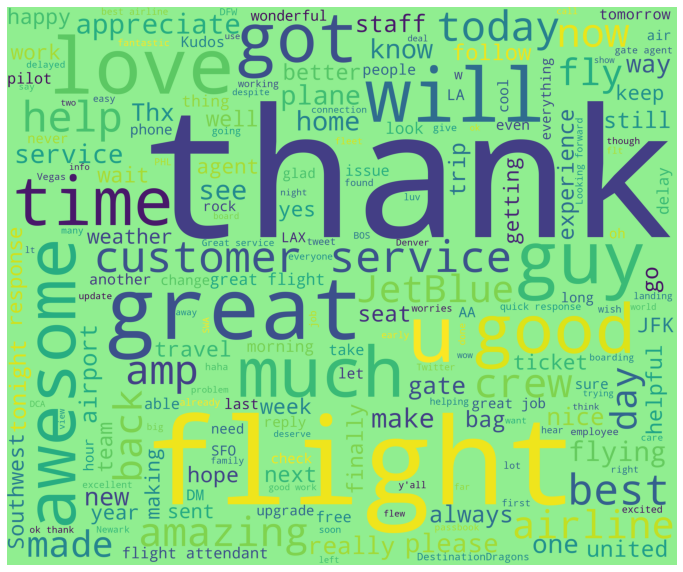

In [9]:
new_df=review_data[review_data['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='lightgreen',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


There also seem to be some clear key words for positive reviews, including "thank", "love", "great" and "awesome". Some other words, however, may confuse our machine learning model because they also appear frequently in negative reviews. Words like "flight", "time", and "customer service" will need the context of the rest of the review in order to make an accurate classification.

These word clouds start to give us a better idea of correlations between words and review sentiments, but we can dive a little deeper. Thankfully, the dataset includes a column that categorizes the reasons for differen negative reviews. Lets take a look at **common reasons for negative reviews**.

Text(0.5, 1.0, 'Negative Reasons Distribution')

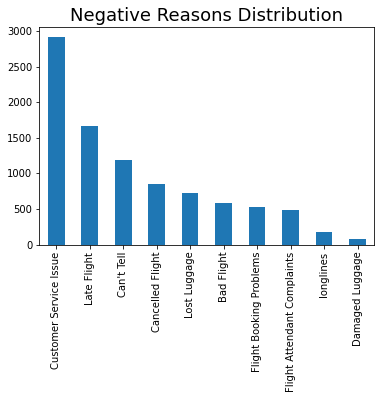

In [10]:
review_data.negativereason.value_counts().plot(kind = "bar")
plt.xticks(rotation=90)
plt.title("Negative Reasons Distribution", size=18)

The top three negative reasons seem to be related to customer service, late flights, cancelled flights. (Unknown was technically third most common, but that's all that useful so might as well just skip to fourth most common.)

However, similar to how we observerved sentiments for individual airlines, let's take a look at specific **negative reasons for individual airlines**.

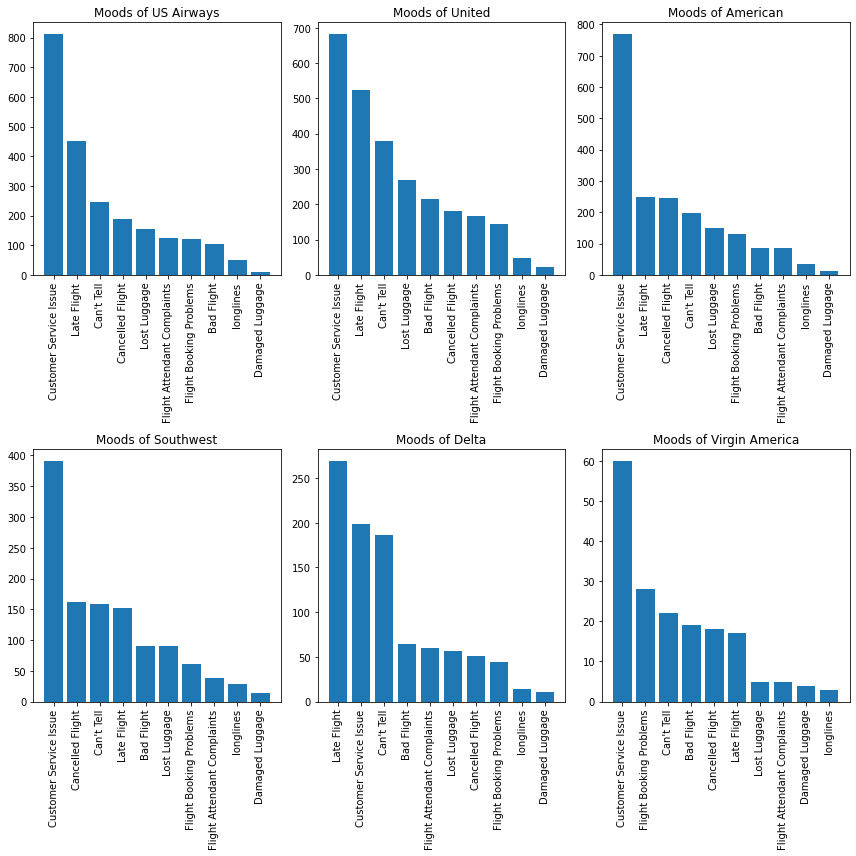

In [11]:
def plot_sub_reason(Airline):
    df=review_data[review_data['airline']==Airline]
    count=df['negativereason'].value_counts()
    Index = range(1,len(count)+1)
    plt.bar(Index,count)
    plt.xticks(Index,count.index,rotation=90)
    plt.title('Moods of '+Airline)
plt.figure(1,figsize=(12, 12),tight_layout=True)
plt.subplot(231) #integers correspond to nrows, ncolumns, and index of the subplot grid. In this case, US Airways is being placed in index 1 of the 2x3 subplot
plot_sub_reason('US Airways')
plt.subplot(232)
plot_sub_reason('United')
plt.subplot(233)
plot_sub_reason('American')
plt.subplot(234)
plot_sub_reason('Southwest')
plt.subplot(235)
plot_sub_reason('Delta')
plt.subplot(236)
plot_sub_reason('Virgin America')

Based on this, we can see that American and Southwest have abnormally higher proportions of **customer service issues**. In addition, Delta actually has more complaints about **late flights** than customer service issues. Virgin America has a uniquely frequent problem with **flight booking**, and United has some more concerns about **lost luggage** than cancelled flights. It seems that every airline has it's own unique aspects that it needs to work on, but the **overall trend of flight timing and customer service** can still help us make some general conclusions and make our machine learning model.

# Data Cleaning
To begin cleaning the data, let's first see how many columns have **missing values**.

In [12]:
for i in review_data.columns:
    print (i + ":")
    print ("\t" + str(sum(review_data[i].isnull()))+" missing values")
    print ("\t" + str(100 * round(sum(review_data[i].isnull())/len(review_data), 3)) + "% missing")

tweet_id:
	0 missing values
	0.0% missing
airline_sentiment:
	0 missing values
	0.0% missing
airline_sentiment_confidence:
	0 missing values
	0.0% missing
negativereason:
	5462 missing values
	37.3% missing
negativereason_confidence:
	4118 missing values
	28.1% missing
airline:
	0 missing values
	0.0% missing
airline_sentiment_gold:
	14600 missing values
	99.7% missing
name:
	0 missing values
	0.0% missing
negativereason_gold:
	14608 missing values
	99.8% missing
retweet_count:
	0 missing values
	0.0% missing
text:
	0 missing values
	0.0% missing
tweet_coord:
	13621 missing values
	93.0% missing
tweet_created:
	0 missing values
	0.0% missing
tweet_location:
	4733 missing values
	32.300000000000004% missing
user_timezone:
	4820 missing values
	32.9% missing


Based on this, we can see that **airline_sentiment_gold**, **negativereason_gold**, and **tweet_coord** all have **over 90% of their values missing**. These are not worth filling in, so we can just **drop those columns**.

In [13]:
review_data.drop(['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'], axis=1, inplace=True)

Next, we will probably need to clean up the words of the actual review tweets. Let's take a look at an example tweet to see what we need to do.

In [14]:
print(review_data.text[1])
print(review_data.text[5])
print(review_data.text[9])

@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.


Here, we can see that there are some words which are not particularly useful, such as "the", "and", and "to". Thankfully, there is already a classification for these words called **stopwords**. Let's try to remove them in addition to the @mentions of specific airlines so that this model can be applied to all airlines.

In [15]:
review_data['original_text'] = review_data.text

def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via exceptions
    exceptions = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in exceptions or exceptions[0] in word) and len(word) > 1] 
    return " ".join(clean_words).lower()
    
def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)

#def remove_symbols(input_text):
#    return " ".join(re.sub(r'[^\w]', ' ', input_text).split())
       
review_data.text = review_data.text.apply(remove_stopwords).apply(remove_mentions)#.apply(remove_symbols)
print(review_data.text[1])
print(review_data.text[5])
print(review_data.text[9])

 plus added commercials experience... tacky.
 seriously would pay $30 flight seats didn't playing. really bad thing flying va
 amazing, arrived hour early. you're good me.


Before we continue cleaning the text data, let's quickly create a new column to simplify the sentiments from words to binary **1's (positive/neutral)** or **0's (negative)**.

In [16]:
review_data["sentiment"] = review_data["airline_sentiment"].apply(lambda x: 0 if x=='negative' else 1)
review_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,original_text,sentiment
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,what said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),@VirginAmerica What @dhepburn said.,1
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,plus added commercials experience... tacky.,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),@VirginAmerica plus you've added commercials t...,1
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,didn't today... must mean need take another t...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),@VirginAmerica I didn't today... Must mean I n...,1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,"really aggressive blast obnoxious ""entertainm...",2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),@VirginAmerica it's really aggressive to blast...,0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,really big bad thing,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),@VirginAmerica and it's a really big bad thing...,0


With the sentiment column ready, we can do train/test split to finalize our text features.

In [17]:
y = review_data.sentiment
X = review_data[['tweet_id', 'text']]
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size = 0.2, random_state = 1)

Now let's take our cleaned text and converting them to tokens for proper machine learning.

In [18]:
v = CountVectorizer(analyzer = "word")
train_features= v.fit_transform(train_X.text)
test_features=v.transform(val_X.text)

# Model Building
Next, let's begin building our machine learning models and comparing methods.

### Random Forest Classifier

In [19]:
model = RandomForestClassifier(random_state=1)
model.fit(train_features,train_y)
forest_predictions = model.predict(test_features)
print('The accuracy of the Random Forest Classifier is',round(accuracy_score(val_y,forest_predictions)*100,2))
forest_accuracy = round(accuracy_score(val_y,forest_predictions)*100,2)

The accuracy of the Random Forest Classifier is 82.1


### Gradient Boosting Classifier

In [20]:
model = GradientBoostingClassifier(random_state=1)
model.fit(train_features,train_y)
gradient_predictions = model.predict(test_features)
print('The accuracy of the Gradient Boosting Classifier is',round(accuracy_score(val_y,gradient_predictions)*100,2))
gradient_accuracy = round(accuracy_score(val_y,gradient_predictions)*100,2)

The accuracy of the Gradient Boosting Classifier is 73.98


### Deep Learning

Epoch 1/50
46/46 [==============================] - 10s 208ms/step - loss: 0.9199 - binary_accuracy: 0.6617 - val_loss: 0.5137 - val_binary_accuracy: 0.8289
Epoch 2/50
46/46 [==============================] - 9s 194ms/step - loss: 0.2855 - binary_accuracy: 0.9294 - val_loss: 0.8140 - val_binary_accuracy: 0.8391
Epoch 3/50
46/46 [==============================] - 8s 184ms/step - loss: 0.1779 - binary_accuracy: 0.9710 - val_loss: 0.9731 - val_binary_accuracy: 0.8405
Epoch 4/50
46/46 [==============================] - 8s 183ms/step - loss: 0.1349 - binary_accuracy: 0.9871 - val_loss: 1.0083 - val_binary_accuracy: 0.8361


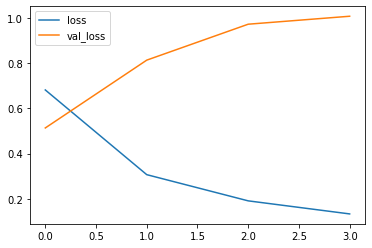

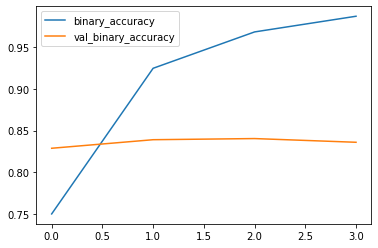

In [21]:
dl_train_features = train_features.toarray()
dl_test_features = test_features.toarray()

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=3, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[12533]),
    layers.Dropout(0.3),
    layers.Dense(1024),
    layers.Dropout(0.3),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    dl_train_features, train_y,
    validation_data=(dl_test_features, val_y),
    batch_size=256,
    epochs=50,
    callbacks=[early_stopping],
)

# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df[['loss', 'val_loss']].plot();
history_df[['binary_accuracy', 'val_binary_accuracy']].plot();
keras_accuracy = round(history_df['val_binary_accuracy'].iloc[-1]*100,2)

keras_predictions = np.where(model.predict(dl_test_features) > 0.5, 1,0)

# Conclusions

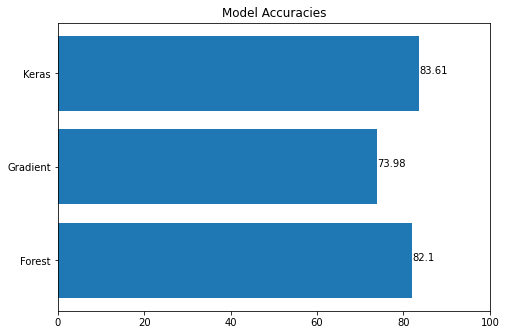

In [22]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['Forest', 'Gradient', 'Keras']
accuracies = [forest_accuracy, gradient_accuracy, keras_accuracy]
ax.barh(models,accuracies)
for index, value in enumerate(accuracies):
    plt.text(value, index, str(value))
plt.title('Model Accuracies')
plt.xlim([0, 100])
plt.show()

Based on this, the keras deep learning model seems to have the highest accuracy, followed closely by random forests, and then gradient boosting came in last. 
Let's try to see some specific **examples of predictions**, and we can start by verifying that all our model outputs are the same length and format.

In [23]:
print(forest_predictions)
print(gradient_predictions)
temp = [item for sublist in keras_predictions for item in sublist]
keras_predictions = np.array(temp)
print(keras_predictions)
print(len(forest_predictions))
print(len(gradient_predictions))
print(len(keras_predictions))

[1 0 1 ... 0 0 1]
[0 0 0 ... 0 1 0]
[1 0 1 ... 0 0 1]
2928
2928
2928


Next, we'll create a new dataframe to specifically compare predictions with the actual values and tweets. We will use the tweet_id to ensure that we consistently look at the correct tweets.

In [24]:
true_sentiments = []
original_text = []
for tweet in val_X.tweet_id.to_numpy():
    true_sentiments.append(review_data.loc[review_data['tweet_id'] == tweet]['sentiment'].iloc[0])
    original_text.append(review_data.loc[review_data['tweet_id'] == tweet]['original_text'].iloc[0])
output = pd.DataFrame({
    'tweet_id': val_X.tweet_id, 
    'original_text': original_text,
    'clean_text': val_X.text,
    'sentiment': true_sentiments, 
    'forest': forest_predictions, 
    'gradient': gradient_predictions, 
    'keras': keras_predictions
})
output

,tweet_id,original_text,clean_text,sentiment,forest,gradient,keras
8515,568198336651649027,@JetBlue I'll pass along the advice. You guys ...,i'll pass along advice. you guys rock!!,1,1,0,1
3439,568438094652956673,@united I sent you a dm with my file reference...,sent dm file reference number.. want know som...,0,0,0,0
6439,567858373527470080,@SouthwestAir Black History Commercial is real...,black history commercial really sweet. well d...,1,1,0,1
5112,569336871853170688,@SouthwestAir why am I still in Baltimore?! @d...,still baltimore?! laps around us laughing it...,0,0,0,0
5645,568839199773732864,@SouthwestAir SEA to DEN. South Sound Volleyba...,sea den. south sound volleyball team way! htt...,1,1,1,1
...,...,...,...,...,...,...,...
11412,568135319876468736,Yes but I will nvr fly w/ @USAirways I missed ...,yes nvr fly w/ missed con flight bc coffeemak...,0,0,0,0
10581,569164183473762304,@USAirways Official time of call 3 hours 10 mi...,official time call hours 10 minutes must add ...,0,0,0,0
1986,569491295766343681,@united On hold 2X 60 min ea. Trying to bk a t...,on hold 2x 60 min ea. trying bk tix asia. you...,0,0,0,0
3267,568562804837490688,@united wasting time at baggage claim thanks t...,wasting time baggage claim thanks dfw ground ...,0,0,1,0


Finally, we can look for some good examples of predictions.

In [25]:
#Looking for sample predictions
pd.set_option('display.max_rows', 10)
print(output.loc[(output.sentiment != output.forest) & (output.sentiment != output.gradient) & (output.sentiment != output.keras)][['tweet_id', 'original_text']])

print(output.loc[output.tweet_id == 567764034418909186].original_text.item()) #Obvious positive review, all models got it right
print(output.loc[output.tweet_id == 569336871853170688].original_text.item()) #Obvious negative review, all models got it right
print(output.loc[output.tweet_id == 570302023968694272].original_text.item()) #Kinda both, all models got it wrong
print(output.loc[output.tweet_id == 568491900195500032].original_text.item()) #Sarcasm, all models couldn't detect it

                 tweet_id                                      original_text
12866  569997196298293249  @AmericanAir #epicfail on connections in #Chic...
12419  570194141612789760  @AmericanAir travel week, delays, Cancelled Fl...
9572   569870374638235649  @USAirways &amp; @AmericanAir what are your we...
1956   569504232971362304  @united Was on NH10 on United ticket, rerouted...
3308   568536646963970048  @united  I'm on standby for my connecting flig...
...                   ...                                                ...
6874   570073661241057280  @JetBlue Happy Anniversary!! It's hard to beli...
2795   568895856750899202  @united how long does it take for customer fee...
5197   569262065988308993  @SouthwestAir How can you get your TSA travele...
2019   569471635163643905  @united @suntoshi I still like you united airl...
4555   570032108447494144  @SouthwestAir No monkey business we luv SWA!! ...

[259 rows x 2 columns]
@SouthwestAir Another great flight &amp; crew, Las V

As we can see, all three models were able to correctly categorize the sentiments of some obvious positive and negative reviews. On the other hand, some more ambiguous and sarcastic reviews went under the radar of all three tweets. Clearly these models are not perfect, but they have reached a point where they can provide reasonably accurate predictions so that market researchers can help their companies choose which areas to improve upon.

This has been a fun exploration of airline reviews, and the natural language processing methods that were used for this project could be applied well to many other industries! It will be exciting to continue similar research and begin applying this technology to new problems.